In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Configuration

In [31]:
TARGET = "pollutant"
DATA_PATH = "datasets"

API_URLS = [
    "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/first",
    "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/second",
    "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/third"
]

DATASET_DTYPES = {
    "CITY ID": "object",
    "CONTINENT": "object",
    "City": "object",
    "DAY": "int8",
    "DAY WITH FOGS": "int8",
    "EPRTRAnnexIMainActivityCode": "object",
    "EPRTRAnnexIMainActivityLabel": "object",
    "EPRTRSectorCode": "int8",
    "FacilityInspireID": "object",
    "MONTH": "int8",
    "REPORTER NAME": "object",
    "avg_temp": "float64",
    "avg_wind_speed": "float64",
    "countryName": "object",
    "eprtrSectorName": "object",
    "facilityName": "object",
    "max_temp": "float64",
    "max_wind_speed": "float64",
    "min_temp": "float64",
    "min_wind_speed": "float64",
    "pollutant": "object",
    "reportingYear": "int8",
    "targetRelease": "object"
}

## Classes

In [32]:
class ApiDataConsumer:

    def __init__(self, urls, dtypes = None):
        self.urls = urls
        self.dtypes = dtypes

    def get_api_df(self, verbose: bool = True) -> pd.DataFrame:
        if verbose:
            print("Getting data from API")
        api_df = None
        for url in self.urls:
            json_df = pd.read_json(url, dtype=self.dtypes)
            json_df = json_df.drop("", axis=1)

            if verbose:
                print(f"url: {url} json_df.shape: {json_df.shape}")

            if api_df is not None:
                api_df = pd.concat([api_df, json_df])
            else:
                api_df = json_df

        return api_df


class FeatureGenerator:

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy(deep=True)

    def encode(self, columns, agg_func = None) -> pd.DataFrame:
        if agg_func is None:
            agg_func = self.__my_agg

        for column in columns:
            gb_df_ = self.df.groupby(column).apply(agg_func, column_name=column).reset_index()
            self.df = pd.merge(left=self.df, right=gb_df_, on=column, how="left")

        return self.df.drop(columns, axis=1)

    @staticmethod
    def __my_agg(full_df_: pd.DataFrame, column_name: str) -> pd.Series:
        column_name = column_name.replace(" ", "_").lower()
        names = {
            '{}_avg_temperature'.format(column_name):  full_df_['avg_temp'].mean(),
            '{}_avg_wind_speed'.format(column_name):  full_df_['avg_wind_speed'].mean(),
        }
        return pd.Series(names, index = [key for key in names.keys()])

## Functions

In [33]:
def one_hot_encode(dataframe: pd.DataFrame, column_name: str) -> pd.DataFrame:
    _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix=column_name)
    return pd.concat([dataframe, _dummy_dataset], axis=1).drop([column_name], axis=1)

def encode_dataframe(dataframe: pd.DataFrame, cat_columns) -> pd.DataFrame:
    print(f"columns to encode: {cat_columns}")

    print(f"dataframe before one-hot encoding: {dataframe.shape}")
    for cat_col in cat_columns:
        dataframe = one_hot_encode(dataframe, cat_col)

    print(f"dataframe after one-hot encoding:  {dataframe.shape}")
    return dataframe

## Load data

In [34]:
apiDataConsumer = ApiDataConsumer(API_URLS, DATASET_DTYPES)

In [35]:
%%time
train1_df = pd.read_csv(f"{DATA_PATH}/train1.csv", dtype=DATASET_DTYPES)
print('* train1 loaded... shape:', train1_df.shape)

train2_df = pd.read_csv(f"{DATA_PATH}/train2.csv", dtype=DATASET_DTYPES, sep=";")
print('* train2 loaded... shape:', train2_df.shape)

api_df = apiDataConsumer.get_api_df(verbose=False)
print('* api_df loaded... shape:', api_df.shape)

* train1 loaded... shape: (18563, 21)
* train2 loaded... shape: (18564, 21)
* api_df loaded... shape: (28501, 23)
Wall time: 11 s


In [36]:
raw_df = pd.concat([train1_df, train2_df, api_df], axis=0, ignore_index=True)
print('* raw_df shape:', raw_df.shape)
raw_df.head()

* raw_df shape: (65628, 23)


,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,...,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID,EPRTRAnnexIMainActivityCode,EPRTRSectorCode
0,Germany,Mineral industry,Installations for the production of cement cli...,https://registry.gdi-de.org/id/de.ni.mu/062217...,Holcim (Deutschland) GmbH Werk Höver,Sehnde,AIR,Carbon dioxide (CO2),-33,10,...,14.312541,21.419106,2.864895,4.924169,9.688206,2,Mr. Jacob Ortega,7cdb5e74adcb2ffaa21c1b61395a984f,NaN,NaN
1,Italy,Mineral industry,Installations for the production of cement cli...,IT.CAED/240602021.FACILITY,Stabilimento di Tavernola Bergamasca,TAVERNOLA BERGAMASCA,AIR,Nitrogen oxides (NOX),-30,9,...,19.368166,21.756389,5.462839,7.864403,12.023521,1,Ashlee Serrano,cd1dbabbdba230b828c657a9b19a8963,NaN,NaN
2,Spain,Waste and wastewater management,Landfills (excluding landfills of inert waste ...,ES.CAED/001966000.FACILITY,COMPLEJO MEDIOAMBIENTAL DE ZURITA,PUERTO DEL ROSARIO,AIR,Methane (CH4),-29,2,...,14.701985,17.103930,1.511201,4.233438,8.632193,2,Vincent Kemp,5011e3fa1436d15b34f1287f312fbada,NaN,NaN
3,Czechia,Energy sector,Thermal power stations and other combustion in...,CZ.MZP.U422/CZ34736841.FACILITY,Elektrárny Prunéřov,Kadaň,AIR,Nitrogen oxides (NOX),-36,8,...,16.122584,17.537184,10.970301,10.298348,15.179215,0,Carol Gray,37a6d7a71c4f7c2469e4f01b70dd90c2,NaN,NaN
4,Finland,Waste and wastewater management,Urban waste-water treatment plants,http://paikkatiedot.fi/so/1002031/pf/Productio...,"TAMPEREEN VESI LIIKELAITOS, VIINIKANLAHDEN JÄT...",Tampere,AIR,Methane (CH4),-30,12,...,20.201604,21.536012,11.772039,11.344078,16.039004,2,Blake Ford,471fe554e1c62d1b01cc8e4e5076c61a,NaN,NaN


## EDA

In [37]:
raw_df[TARGET].value_counts()

Nitrogen oxides (NOX)    25982
Carbon dioxide (CO2)     22964
Methane (CH4)            16682
Name: pollutant, dtype: int64

MONTH


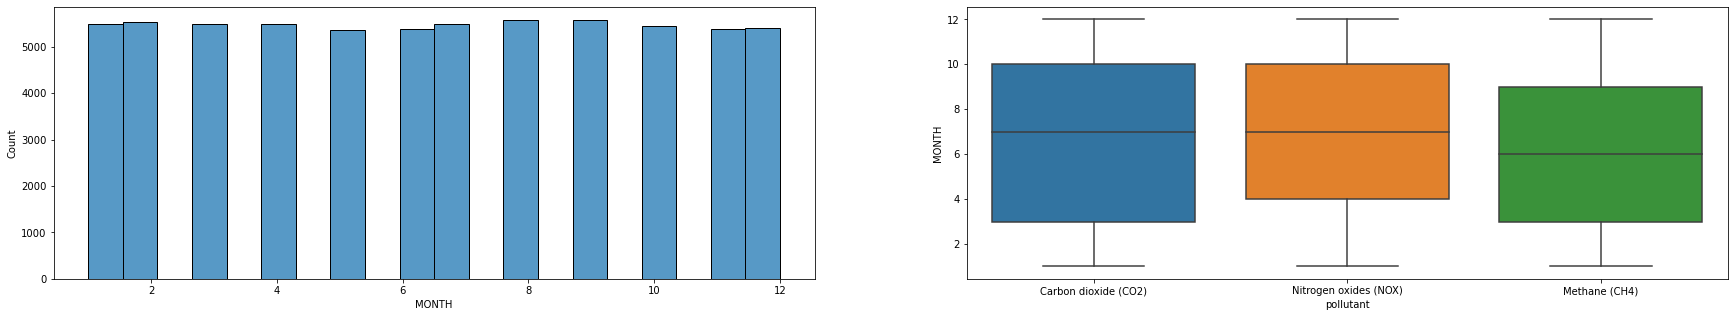

avg_temp


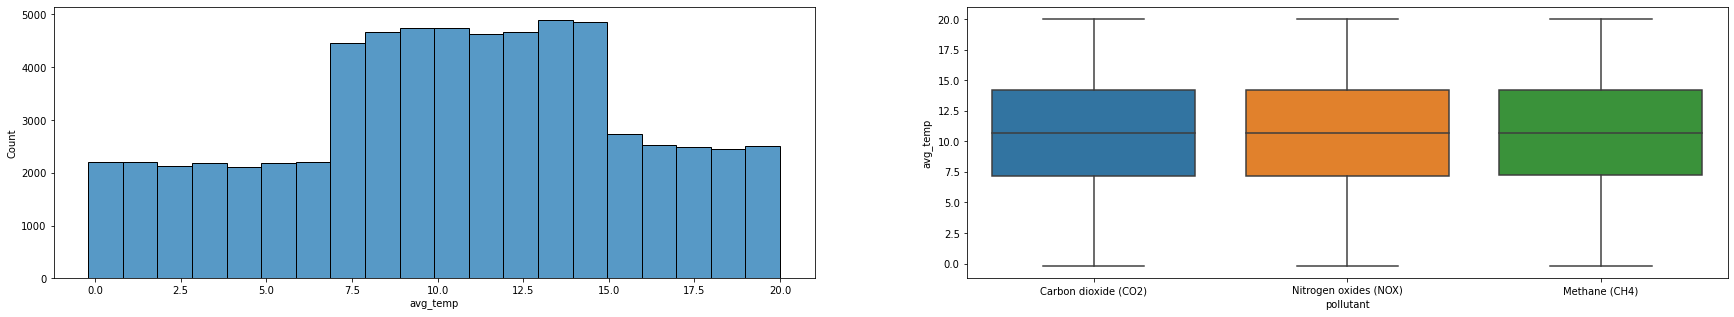

avg_wind_speed


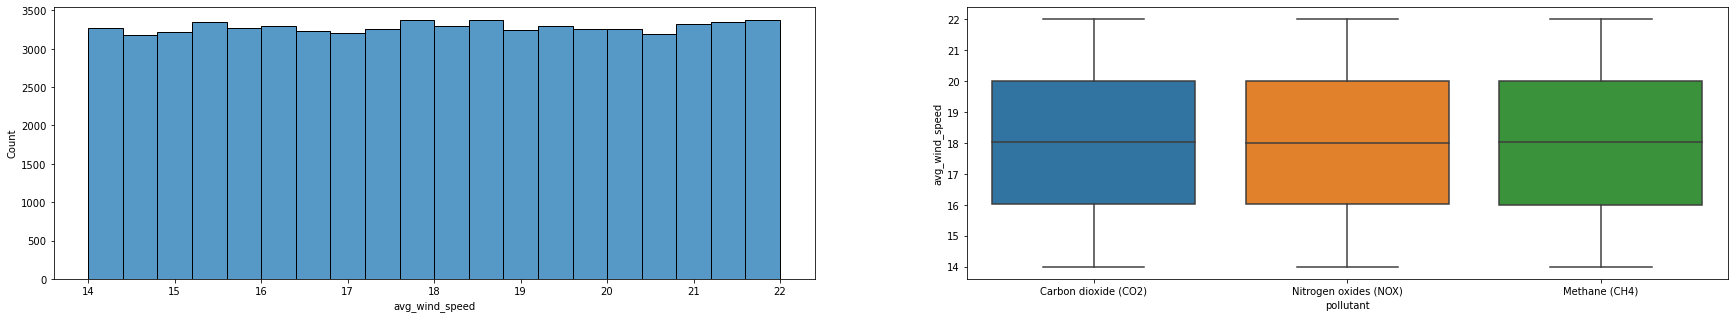

In [44]:
numeric_columns = ["MONTH", "avg_temp", "avg_wind_speed"]
for col in numeric_columns:
    print(col)
    f, (ax_hist, ax_box) = plt.subplots(1, 2, figsize=(30, 5))
    sns.histplot(data=raw_df, x=col, ax=ax_hist, bins=20)
    sns.boxplot(data=raw_df, x=TARGET, y=col)
    plt.show()

In [47]:
categorical_columns = ["countryName", "eprtrSectorName"]

countryName


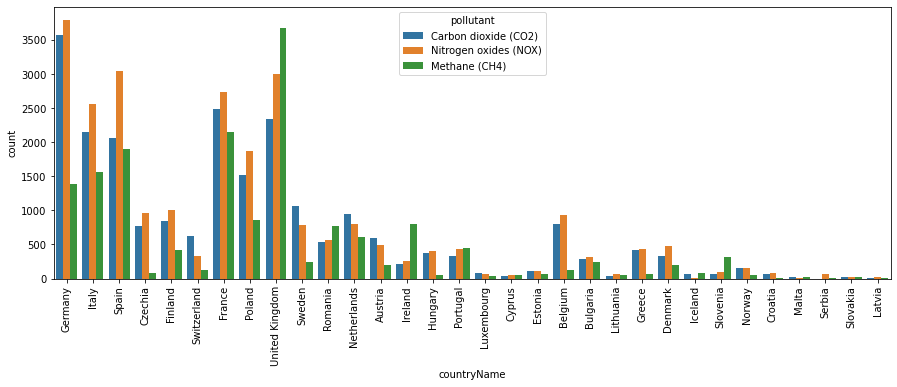

eprtrSectorName


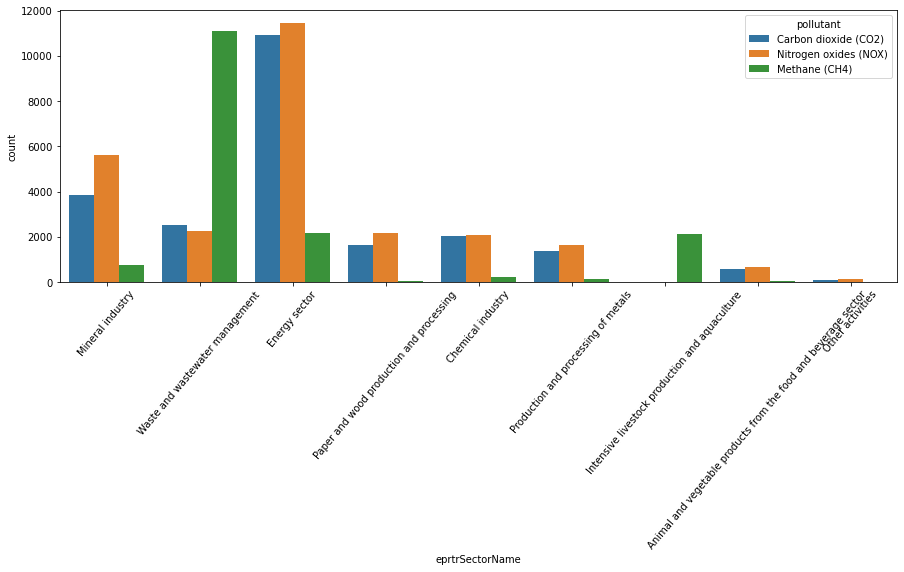

In [62]:
for col in categorical_columns:
    print(col)
    plt.figure(figsize=(15, 5))
    if len(raw_df[col].unique()) > 13:
        plt.xticks(rotation=90)
    elif len(raw_df[col].unique()) > 8:
        plt.xticks(rotation=50)
    sns.countplot(data=raw_df, x=col, hue=TARGET)
    plt.show()

## Preprocessing

In [20]:
prep_df = raw_df.copy(deep=True)

In [21]:
prep_df.describe(exclude=np.number).T

,count,unique,top,freq
countryName,65628,32,United Kingdom,9016
eprtrSectorName,65628,9,Energy sector,24562
EPRTRAnnexIMainActivityLabel,65628,71,Thermal power stations and other combustion in...,21527
FacilityInspireID,65628,7185,https://data.ied_registry.omgeving.vlaanderen....,42
facilityName,65628,7930,Enel Produzione S.p.A.,234
City,65628,5136,--,1975
targetRelease,65628,1,AIR,65628
pollutant,65628,3,Nitrogen oxides (NOX),25982
CONTINENT,65628,1,EUROPE,65628
REPORTER NAME,65628,45016,Michael Brown,25


In [22]:
to_remove = [
    "EPRTRSectorCode",
    "EPRTRAnnexIMainActivityCode",

    "targetRelease",
    "City",
    "CONTINENT",

    "REPORTER NAME"
]

prep_df = prep_df.drop(to_remove, axis=1)
print(f"prep_df after drop columns {prep_df.shape}")

prep_df after drop columns (65628, 17)


In [23]:
feature_generator = FeatureGenerator(prep_df)

In [24]:
to_encode = [
    "FacilityInspireID",
    "facilityName",
    "CITY ID",
]

prep_df = feature_generator.encode(to_encode)
print(f"prep_df after encode {prep_df.shape}")

prep_df after encode (65628, 20)


In [25]:
to_one_hot_encode = [
    "countryName",
    "eprtrSectorName",
    "EPRTRAnnexIMainActivityLabel"
]

prep_df = encode_dataframe(prep_df, to_one_hot_encode)

columns to encode: ['countryName', 'eprtrSectorName', 'EPRTRAnnexIMainActivityLabel']
dataframe before one-hot encoding: (65628, 20)
dataframe after one-hot encoding:  (65628, 129)


In [26]:
dict_target = {
    "Nitrogen oxides (NOX)": 0,
    "Carbon dioxide (CO2)": 1,
    "Methane (CH4)": 2,
}
prep_df[TARGET] = prep_df[TARGET].apply(lambda value: dict_target[value])

## Modelling

In [30]:
train_df = prep_df.copy(deep=True)